# Построение модели на примере полиномиальной регрессии (polynomial regression) с использованием `sklearn.pipeline`

## Подготовка окружения

In [1]:
# ВНИМАНИЕ: необходимо удостовериться, что виртуальная среда выбрана правильно!

# Для MacOS/Ubuntu
# !which pip

# Для Windows
# !where pip

In [2]:
# !conda install matplotlib numpy scikit-learn seaborn scipy -y

In [3]:
# !conda install -c conda-forge imbalanced-learn

In [4]:
import numpy as np

np.__version__

'1.19.2'

In [5]:
import pandas as pd

pd.__version__

'1.2.3'

In [6]:
import scipy
from scipy import stats

scipy.__version__

'1.6.2'

In [7]:
import matplotlib
import matplotlib.pyplot as plt

matplotlib.__version__

'3.3.4'

In [8]:
import seaborn as sns

sns.__version__

'0.11.1'

In [9]:
import imblearn
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

imblearn.__version__

'0.8.0'

In [10]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.preprocessing import RobustScaler

from sklearn.preprocessing import KBinsDiscretizer

from sklearn.tree import DecisionTreeClassifier

from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
# from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [11]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report

from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import plot_precision_recall_curve

## Загрузка данных

[Источник (Churn Modelling)](https://www.kaggle.com/shrutimechlearn/churn-modelling)

In [12]:
df = pd.read_csv("./../../data/Churn_Modelling.csv", index_col=0)
df

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,,,
1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9996,15606229,Obijiaku,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9997,15569892,Johnstone,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9998,15584532,Liu,709,France,Female,36,7,0.00,1,0,1,42085.58,1


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1 to 10000
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerId       10000 non-null  int64  
 1   Surname          10000 non-null  object 
 2   CreditScore      10000 non-null  int64  
 3   Geography        10000 non-null  object 
 4   Gender           10000 non-null  object 
 5   Age              10000 non-null  int64  
 6   Tenure           10000 non-null  int64  
 7   Balance          10000 non-null  float64
 8   NumOfProducts    10000 non-null  int64  
 9   HasCrCard        10000 non-null  int64  
 10  IsActiveMember   10000 non-null  int64  
 11  EstimatedSalary  10000 non-null  float64
 12  Exited           10000 non-null  int64  
dtypes: float64(2), int64(8), object(3)
memory usage: 1.1+ MB


## Разделение данных на `X` и `y`

In [14]:
# колонка, которая не несет полезной информации
# если добавить, то может испортить качество, так как
# номер пользователя объективно не должен влиять на результат
del df['CustomerId']

In [15]:
target_column_name = 'Exited'

In [16]:
from sklearn.model_selection import train_test_split

y = df[target_column_name].copy()
X = df.loc[:, df.columns != target_column_name].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Анализ и обработка пропущенных значений

In [17]:
df.isna().sum()

Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

## Преобразование типов и очистка

In [18]:
for col_name in X_train.select_dtypes(include='object'):
    print(f'{col_name} : {X_train[col_name].nunique()}')
    print('-' * 20)

Surname : 2596
--------------------
Geography : 3
--------------------
Gender : 2
--------------------


In [19]:
for col_name in X_train.select_dtypes(include=int):
    nunique = X_train[col_name].nunique()
    
    print(f'{col_name} : {nunique}')
    if nunique < 40:
        display(X_train[col_name].value_counts())
    print('-' * 20)

CreditScore : 456
--------------------
Age : 70
--------------------
Tenure : 11


2     839
1     837
7     833
5     821
3     821
8     816
4     787
9     774
6     757
10    401
0     314
Name: Tenure, dtype: int64

--------------------
NumOfProducts : 4


1    4046
2    3698
3     209
4      47
Name: NumOfProducts, dtype: int64

--------------------
HasCrCard : 2


1    5631
0    2369
Name: HasCrCard, dtype: int64

--------------------
IsActiveMember : 2


1    4095
0    3905
Name: IsActiveMember, dtype: int64

--------------------


## Анализ баланса целевой переменной (`y`)

In [20]:
def plot_cat_count_s(cs: pd.Series):
    """
    Функция для рисования countplot для Series
    """
    fig, ax = plt.subplots(1, 1, figsize=(6, 2))
    g = sns.countplot(x=cs, 
                      ax=ax)
    g.set_xticklabels(g.get_xticklabels(), 
                      rotation=45, 
                      horizontalalignment='right')

    ax.xaxis.label.set_visible(False)
    ax.yaxis.label.set_visible(False)

    ax.set_title(cs.name, 
                 loc='right', 
                 fontsize=15)
    ax.grid()

    total = len(cs)
    
    print(f"{total} ({cs.name})")

    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x_pos = p.get_x()
        y_pos = p.get_y() + p.get_height()
        ax.annotate(percentage, 
                    xy=(x_pos, y_pos), 
                    fontsize=15)

10000 (Exited)


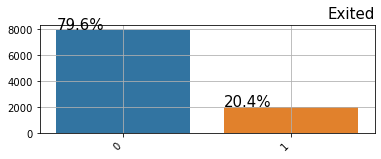

In [21]:
plot_cat_count_s(y)

Можно сказать, что имеется умеренная (moderate) несбалансированность классов.

## Анализ и обработка выбросов

In [22]:
def box_hist(data, col_name):
    _, axs = plt.subplots(1, 2, figsize=(10, 2))
    sns.boxplot(data=data[col_name], ax=axs[0])
    sns.histplot(data=data[col_name], ax=axs[1])

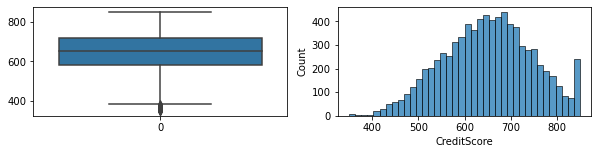

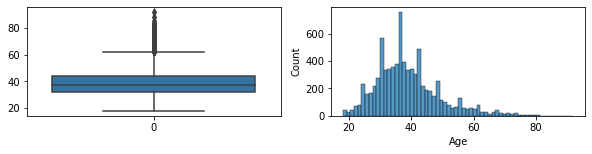

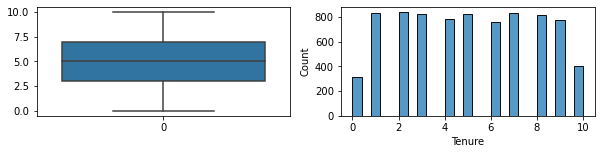

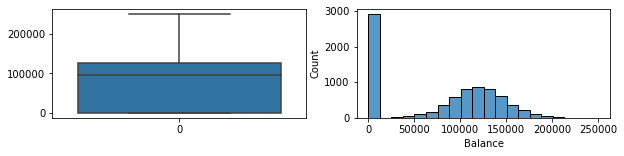

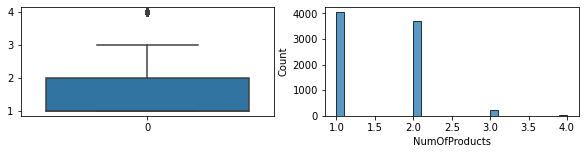

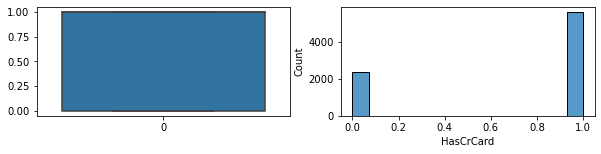

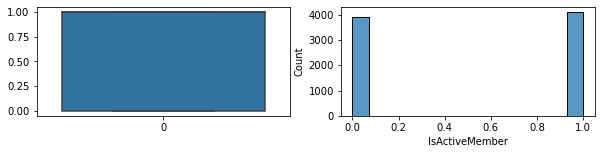

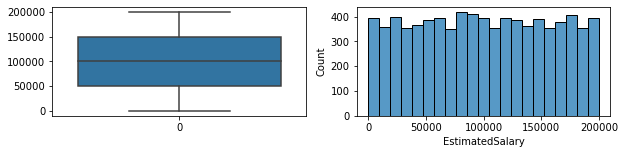

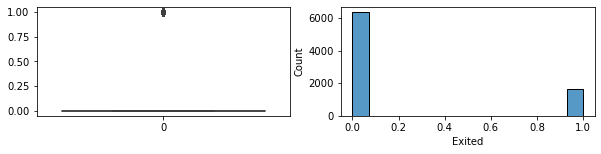

In [23]:
df_train = X_train.join(y_train).reset_index(drop=True)
for col_name in df_train.select_dtypes(include=np.number):
    box_hist(df_train, col_name)

X_train = df_train.loc[:, df_train.columns != target_column_name].copy()
y_train = df_train[target_column_name].copy()

## Анализ корреляции

In [24]:
corr_matrix = df_train.select_dtypes(include=np.number).corr(method='spearman')
corr_matrix[(abs(corr_matrix)) > 0.5]

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
CreditScore,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Tenure,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
Balance,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
NumOfProducts,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
HasCrCard,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
IsActiveMember,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
EstimatedSalary,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
Exited,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


## Pipeline

In [25]:
cat_columns = ['Gender', 'NumOfProducts']
bool_columns = ['HasCrCard', 'IsActiveMember']
num_columns = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary', 'Tenure']
str_columns = ['Surname', 'Geography']

In [26]:
bin_cat_columns = [col_name for col_name in X[cat_columns] if X[col_name].nunique() == 2]
mul_cat_columns = [col_name for col_name in cat_columns if col_name not in bin_cat_columns]
bin_columns = bin_cat_columns + bool_columns

print(f"cat_columns: {cat_columns}")
print(f"bin_cat_columns: {bin_cat_columns}")
print(f"mul_cat_columns: {mul_cat_columns}")
print(f"bool_columns: {bool_columns}")
print(f"bin_columns: {bin_columns}")
print(f"num_columns: {num_columns}")
print(f"str_columns: {str_columns}")

cat_columns: ['Gender', 'NumOfProducts']
bin_cat_columns: ['Gender']
mul_cat_columns: ['NumOfProducts']
bool_columns: ['HasCrCard', 'IsActiveMember']
bin_columns: ['Gender', 'HasCrCard', 'IsActiveMember']
num_columns: ['CreditScore', 'Age', 'Balance', 'EstimatedSalary', 'Tenure']
str_columns: ['Surname', 'Geography']


In [27]:
bin_cat_transformer = Pipeline(steps=[
    ('encoder_ord', OrdinalEncoder())
])

mul_cat_transformer = Pipeline(steps=[
    ('replace', FunctionTransformer(lambda x: x.replace(4, 3)))
])

num_transformer = Pipeline(steps=[
#     ('discretizer', KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='kmeans'))
    ('scaler', RobustScaler())
])

In [28]:
preprocessor = ColumnTransformer(
    transformers=[
        ('bin_cat_transformer', bin_cat_transformer, bin_columns),
#         ('mul_cat_transformer', mul_cat_transformer, mul_cat_columns),
        ('num_transformer', num_transformer, num_columns),
        ('passthrough', 'passthrough', mul_cat_columns),
        ('drop', 'drop', str_columns),
])

In [29]:
# X[bin_columns + mul_cat_columns + num_columns]

In [30]:
# prep_for_test = preprocessor.fit(X_train, y_train)
# pd.DataFrame(prep_for_test.transform(X_train), columns=bin_columns + mul_cat_columns + num_columns)

## Обучение модели (эксперименты)

In [31]:
pipeline_without_resampling = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('model', DecisionTreeClassifier(criterion='entropy'))
])

pipeline_over_sampling = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('over_sample', RandomOverSampler()),
    ('model', DecisionTreeClassifier(criterion='entropy'))
])

pipeline_SMOT = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('over_sample', SMOTE()),
    ('model', DecisionTreeClassifier(criterion='entropy'))
])

param_grid_without_resampling = {
    'model__max_depth': list(range(3, 8)),
    'model__min_samples_split': list(range(2, 8))
}

param_grid_over_sampling = {
    'model__max_depth': list(range(3, 8)),    
    'model__min_samples_split': list(range(2, 8)),
    'over_sample__sampling_strategy': list(np.arange(0.4, 1, 0.1))
}

param_grid_SMOT = {
    'model__max_depth': list(range(3, 8)),    
    'model__min_samples_split': list(range(2, 8)),
    'over_sample__sampling_strategy': list(np.arange(0.4, 1, 0.1)),
    'over_sample__k_neighbors': list(range(3, 7))
}

In [32]:
params = {'without_resampling': (pipeline_without_resampling, param_grid_without_resampling), 
          'over_sampling': (pipeline_over_sampling, param_grid_over_sampling), 
          'SMOT': (pipeline_SMOT, param_grid_SMOT)
         }

[scoring parameter](https://scikit-learn.org/stable/modules/model_evaluation.html#common-cases-predefined-values)

In [33]:
gs_scoring = ['roc_auc', 
              'recall', 
              'precision', 
              'f1', 
              'balanced_accuracy', 
              'accuracy']

In [ ]:
import time

total = len(params) * len(gs_scoring)
index = 1
models = {}

for name, (pipeline, param_grid) in params.items():
    models[name] = {}
    for scoring in gs_scoring:
        start = time.time()
        print(f"{name} | {scoring} ...", end=' ')
        model = GridSearchCV(pipeline, param_grid, n_jobs=-1, scoring=scoring)
        model.fit(X_train, y_train)
        
        models[name].update({scoring: model})
        end = time.time()

        print(f"finished! ({end - start:0.2f}s) {index}/{total}")
        index += 1
    print()

without_resampling | roc_auc ... finished! (3.48s) 1/18
without_resampling | recall ... finished! (2.06s) 2/18
without_resampling | precision ... finished! (2.05s) 3/18
without_resampling | f1 ... finished! (1.91s) 4/18
without_resampling | balanced_accuracy ... finished! (2.00s) 5/18
without_resampling | accuracy ... finished! (2.06s) 6/18

over_sampling | roc_auc ... finished! (14.97s) 7/18
over_sampling | recall ... finished! (12.33s) 8/18
over_sampling | precision ... finished! (12.60s) 9/18
over_sampling | f1 ... finished! (12.30s) 10/18
over_sampling | balanced_accuracy ... finished! (13.51s) 11/18
over_sampling | accuracy ... finished! (11.85s) 12/18

SMOT | roc_auc ... finished! (87.64s) 13/18
SMOT | recall ... 

## Анализ результатов

In [ ]:
columns = ['accuracy', 'b_accuracy', 'precision', 'recall', 'f1', 'roc_auc']

In [ ]:
def evaluate_model(y_predicted, X_test, y_test):       
    accuracy = accuracy_score(y_test, y_predicted)
    balanced_accuracy = balanced_accuracy_score(y_test, y_predicted)
    precision = precision_score(y_test, y_predicted)
    recall = recall_score(y_test, y_predicted)
    f1 = f1_score(y_test, y_predicted, average='weighted')
    roc_auc = roc_auc_score(y_test, y_predicted)
    
    return pd.Series([accuracy, balanced_accuracy, precision, recall, f1, roc_auc], 
                     index=columns)

In [ ]:
eval_df = pd.DataFrame(columns=columns)
name_scorer_index = []

names_len = len(params)
scorers_len = len(gs_scoring)
fig, axes = plt.subplots(scorers_len, names_len, figsize=(scorers_len*3, names_len*9))

for name_index, (name, models_by_scorer) in enumerate(models.items()):
    
    for scorer_index, (scorer, model) in enumerate(models_by_scorer.items()):
        name_scorer_index.append((name, scorer))

        y_predicted = model.predict(X_test)
        ax=axes[scorer_index][name_index]
        plot_confusion_matrix(model, X_test, y_test, ax=ax)
        ax.set_title(f'{name} ({scorer})')
        
        
        eval_res = evaluate_model(y_predicted, X_test, y_test)        
        eval_df = eval_df.append(eval_res, ignore_index=True)
        
index = pd.MultiIndex.from_tuples(name_scorer_index, names=["name", "scorer"])
eval_df.set_index(index, inplace=True)

print(f'\n\nplot matrix: {scorers_len}x{names_len}')
# расстояние между графиками по горизонтали и вертикали
fig.subplots_adjust(hspace=0.3, wspace=0)

In [ ]:
eval_df

In [ ]:
plt.figure(figsize=(8, 8))
sns.heatmap(eval_df, 
            annot=True, 
            annot_kws={"size": 13}, 
            fmt="1.2f", 
            cmap='RdPu', 
            vmin=-1, 
            vmax=1)

In [ ]:
import joblib

joblib.dump(models['over_sampling']['recall'], './tmp/08_model_over_sampling_recall.pkl')